In [1]:
# for manipulating the PDF
# import fitz
# for OCR using PyTesseract
import re
import os
import cv2                              # pre-processing images
import math
import json
from collections import OrderedDict
import numpy as np
import pandas as pd
import pytesseract                      # extracting text from images
import warnings
import matplotlib.pyplot as plt         # displaying output images
from sklearn.linear_model import LogisticRegression
from numpy import mean
from numpy import std
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import itertools
warnings.filterwarnings("ignore")
from PIL import Image
from sklearn.model_selection import GridSearchCV

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [3]:
os.chdir('C:\\Users\\alper\\OneDrive\\Desktop\\School\\5th Semester\\AIN311\\Project') 
french_filepaths = []
moai_filepaths = []
worldcup_filepaths = []
french_filepaths = [os.path.join("data\\french\\",f) for f in os.listdir("data\\french\\") if f.endswith(".txt")]
moai_filepaths = [os.path.join("data\\moai\\",f) for f in os.listdir("data\\moai\\") if f.endswith(".txt")]
worldcup_filepaths = [os.path.join("data\\worldcup\\",f) for f in os.listdir("data\\worldcup\\") if f.endswith(".txt")]

In [4]:
french_experiments = []
for data_file in french_filepaths:
    df = pd.read_json(data_file, lines = True)
    df["values"]
    french_experiments.append(df)

In [5]:
for text_type, filepaths in zip(["french","moai","worldcup"], [french_filepaths, moai_filepaths, worldcup_filepaths]):
    # Read data
    generic_datalist = []
    for data_file in filepaths:
        with open(data_file) as f:
            lines = f.readlines()

        dataDict = {}
        for i,line in enumerate(lines):
            lineDict = json.loads(line)
            dataDict[i] = lineDict
        generic_datalist.append(dataDict)

    # filter out non-fixation data
    generic_fixation_list = []
    for experiment_dict in generic_datalist:
        trackerDict = {}
        j = 0
        for i in range(len(experiment_dict)):
            if(experiment_dict[i]['category'] == 'tracker'):
                trackerDict[j] = experiment_dict[i]
                j += 1

        fixationDict = {}
        j = 0
        for i in range(len(trackerDict)):
            try:
                if(trackerDict[i]['values']['frame']['fix'] == True):
                    fixationDict[j] = trackerDict[i]
                    j += 1
            except:
                pass
        generic_fixation_list.append(fixationDict)

    # general overview
    print("\n",text_type,": ")
    for i,experiment in enumerate(generic_fixation_list):
        print(str(i) + ":"+ str(len(experiment)), end = ", ")

    # df creation for cond
    generic_list = []
    for experiment_dict in generic_fixation_list:
        experiment_df = pd.DataFrame( columns=list('xy'))
        for i in range(len(experiment_dict)):
            x = experiment_dict[i]['values']['frame']['raw']['x']
            y = experiment_dict[i]['values']['frame']['raw']['y']   
            experiment_df = experiment_df.append({'x':x,'y':y}, ignore_index=True) 
        generic_list.append(experiment_df)

    if (text_type == "french"):
        french_df = generic_list
    elif (text_type == "moai"):
        moai_df = generic_list
    elif (text_type == "worldcup"):
        worldcup_df = generic_list


 french : 
0:841, 1:749, 2:345, 3:334, 4:322, 5:889, 6:140, 7:415, 8:246, 9:602, 10:865, 11:542, 12:308, 13:325, 14:228, 15:924, 16:660, 
 moai : 
0:656, 1:527, 2:290, 3:374, 4:422, 5:193, 6:44, 7:521, 8:271, 9:614, 10:625, 11:544, 12:362, 13:230, 14:250, 15:754, 16:499, 
 worldcup : 
0:673, 1:533, 2:261, 3:336, 4:266, 5:242, 6:91, 7:313, 8:300, 9:475, 10:537, 11:427, 12:208, 13:144, 14:274, 15:726, 16:626, 

In [6]:
french_BoW_list = []
moai_BoW_list = []
worldcup_BoW_list = []
for text_type, dataset in zip(["french","moai","worldcup"], [french_df, moai_df, worldcup_df]):
    screenshot_filepath = "data\\" + text_type + "\\" + text_type + ".png"
    original_image = cv2.imread(screenshot_filepath)
    # convert the image to grayscale
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    # Performing OTSU threshold
    ret, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    rectangular_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 12))

    # Applying dilation on the threshold image
    dilated_image = cv2.dilate(threshold_image, rectangular_kernel, iterations = 1)
    #plt.figure(figsize=(25, 15))
    #plt.imshow(dilated_image)
    #plt.show()

    # Finding contours
    contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Creating a copy of the image
    copied_image = original_image.copy()

    mask = np.zeros(original_image.shape, np.uint8)

    # Looping through the identified contours
    # Then rectangular part is cropped and passed on to pytesseract
    # pytesseract extracts the text inside each contours
    # Extracted text is then written into a text file
    paragraph = ""
    #print(len(contours))
    for experiment_data in dataset:
        bag_of_words = {}
        #print(experiment_data)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            # Cropping the text block for giving input to OCR
            cropped = copied_image[y:y + h, x:x + w]
            
            cv2.rectangle(copied_image, (x, y), (x + w, y + h), (36,255,12), 2)
            # Apply OCR on the cropped image
            text = pytesseract.image_to_string(cropped, lang='eng', config='--oem 3 --psm 1')
            text = text.lower()
            text = re.sub('[^a-z]', ' ', text)
            text = re.sub(r'\s+', '', text)

            insideCond = (experiment_data["x"] >= x) & (experiment_data["x"] < x + w) & (experiment_data["y"] >= y) & (experiment_data["y"] < y + h)
            #print(insideCond)
            boundFixations = experiment_data[insideCond]
            #print(boundFixations)
            for i in range(len(boundFixations)):
                try:
                    count = bag_of_words[str(text)]
                    count += 1
                    bag_of_words.update({str(text):count})
                except:
                    bag_of_words[str(text)] = 1
            #del bag_of_words[""]       
        if (text_type == "french"):
            french_BoW_list.append(bag_of_words)
            #print(french_BoW_list)
        elif (text_type == "moai"):
            moai_BoW_list.append(bag_of_words)
            #print(moai_BoW_list)
        elif (text_type == "worldcup"):
            worldcup_BoW_list.append(bag_of_words)
            #print(worldcup_BoW_list)
    masked = cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)

In [16]:
from math import log
def calculate_tf_idf(bow):
    # Total number of documents in the collection
    N = len(bow)
    # Calculate the tf-idf values for each word
    tf_idf = {}
    for word, count in bow.items():
        # Calculate the term frequency (tf)
        tf = count / sum(bow.values())
      # Calculate the inverse document frequency (idf)
        # idf is defined as log(N / n), where N is the total number of documents
        # and n is the number of documents that contain the word
        n = sum(1 for doc in bow if word in doc)
        idf = log(N / n)
        # Calculate the tf-idf value
        tf_idf[word] = tf * idf
    return tf_idf

In [473]:
# New td-idf lists for all 3 classes are created using convertToAllDict() function above
train_frenchNew = [] # French td-idf list
idx = 0
for bag_of_word in french_BoW_list:
    bag_of_word_tfidf = calculate_tf_idf(bag_of_word)
    x = convertToAllDict(french_BoW_list, bag_of_word_tfidf) 
    x = sum(x)
    train_frenchNew.append([x,train_french[idx][1]] )
    idx += 1

In [497]:
train_worldcupNew = [] # Worldcup td-idf list
idx=0
for bag_of_word in worldcup_BoW_list:
    bag_of_word_tfidf=calculate_tf_idf(bag_of_word)
    x=convertToAllDict(worldcup_BoW_list,bag_of_word_tfidf)
    x=sum(x)
    train_worldcupNew.append( [x,train_worldcup[idx][1]] )
    idx+=1

In [508]:
train_moaiNew = [] # Moai td-idf list
idx=0
for bag_of_word in moai_BoW_list:
    bag_of_word_tfidf=calculate_tf_idf(bag_of_word)
    x=convertToAllDict(moai_BoW_list,bag_of_word_tfidf)
    x=sum(x)
    train_moaiNew.append( [x,train_moai[idx][1]] )
    idx+=1

In [474]:
train_frenchNew = pd.DataFrame(train_frenchNew, columns =['X', 'y']) 

In [592]:
print(train_frenchNew["X"])

0     3.465736
1     3.995518
2     3.731536
3     3.769849
4     3.619465
5     3.992337
6     3.433987
7     3.367296
8     3.496508
9     3.806637
10    3.912023
11    3.809651
12    3.708824
13    3.699031
14    3.332205
15    3.957156
16    3.845480
Name: X, dtype: float64


In [498]:
train_worldcupNew = pd.DataFrame(train_worldcupNew, columns =['X', 'y']) 


In [499]:
train_worldcupNew

,X,y
0,2.397895,2
1,3.428807,5
2,3.401423,1
3,3.195771,1
4,3.080697,2
5,3.197871,1
6,2.890372,3
7,3.255188,4
8,3.212574,4
9,3.477898,3


In [509]:
train_moaiNew = pd.DataFrame(train_worldcupNew, columns =['X', 'y']) 


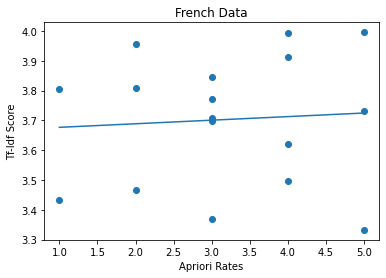

In [513]:
plt.scatter(y=train_frenchNew["X"], x=train_frenchNew["y"])
x=train_frenchNew["y"]
y=train_frenchNew["X"]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('Apriori Rates')
plt.ylabel('Tf-Idf Score')
plt.title("French Data")
plt.show()

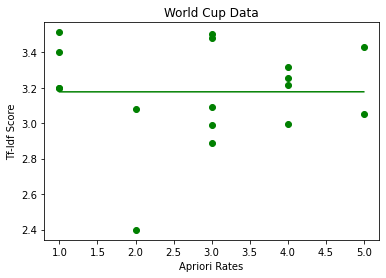

In [520]:
plt.scatter(y=train_worldcupNew["X"], x=train_worldcupNew["y"],c="green")
x=train_worldcupNew["y"]
y=train_worldcupNew["X"]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),c="green")
plt.xlabel('Apriori Rates')
plt.ylabel('Tf-Idf Score')
plt.title("World Cup Data")
plt.show()

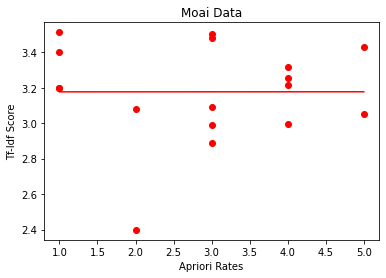

In [587]:
plt.scatter(y=train_moaiNew["X"], x=train_moaiNew["y"], c="red")
x=train_moaiNew["y"]
y=train_moaiNew["X"]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),c="red")
plt.xlabel('Apriori Rates')
plt.ylabel('Tf-Idf Score')
plt.title("Moai Data")
plt.show()

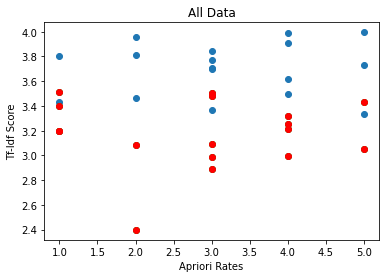

In [521]:
plt.scatter(y=train_frenchNew["X"], x=train_frenchNew["y"])
plt.scatter(y=train_worldcupNew["X"], x=train_worldcupNew["y"],c="green")
plt.scatter(y=train_moaiNew["X"], x=train_moaiNew["y"], c="red")
plt.xlabel('Apriori Rates')
plt.ylabel('Tf-Idf Score')
plt.title("All Data")
plt.show()